# DBDS 202 Problem Set: Data Fusion

## Winter 2023

**NAME:** Jessy Song

### Instructions:

**The goal of this assignment is to get experience combining multiple sources of data through data-fusion to predict Progresson-Free Survival for cancer patients.** The data we are using comes from [this paper](https://www.nature.com/articles/s43018-022-00416-8). In the paper, the authors designed a multi-modal deep learning model to predict which patients with non-small cell lung cancer will respond to immunotherapy (PD-(L)1 therapy).

Deep learning is not a pre-requisite for this class and is not the focus of this assignment, so our goals are slightly simplified. We are using clinical markers, medical imaging, and histopathology to predict Progression-Free Survival (PFS). Again, to reduce reliance on deep learning or image-analysis techniques (although you get experience with those in another homework) we have pre-extracted features from the medical imaging and histopathology images for you already.

We have written some helper functions for you in `train_utils.py` and imported some functions you might want below, but feel free to write or import any other functions you find helpful.

For all written answers, write your response in between the `<font>` tags after <font color='red'> **Answer:** </font> so that your answer appears in red.

In [1]:
# Imports and settings for the notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from train_utils import datasets, train_and_eval_model, run_hparam_search, select_features_with_lasso

from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## 0. Getting to know the data 

Written answers should be 1-3 sentences each in this section. Refer to the source paper for information.

In [2]:
# First we use pandas to read in the labels we will be predicting
pfs = pd.read_csv("pfs.csv")
print(pfs.head())

    pfs  pfs_censor
0   1.6           1
1   7.2           1
2   3.8           1
3   1.9           1
4  14.9           1


In [3]:
pfs.pfs_censor.value_counts()

pfs_censor
1    308
0     58
Name: count, dtype: int64

The name of the first column is 'pfs'. This is short for Progression-Free Survival.

Define Progression-Free Survival and describe how it was calculated in this study. 

<font color='red'>

**Answer:**

Progression-free survival is defined as the length of time during and after treatment of a disease that a patient lives with the disease but does not get worse. In this study, PFS was determined from the date of initiating PD-(L)1 blockade therapy until the date of progression or death (measured duration and record unit is month)


</font>

What type of regression should we use to predict pfs? Linear or logistic? Why? (1-2 sentences)

<font color='red'>

**Answer:**

Linear regression should be used, since the PFS value is recorded as number of months and is a continuous value. Logistic regression is used for categorical classification problem. 

</font>

The second column is 'pfs_censor'. This is a binary value indicating whether a patient's pfs was censored or not. Describe how the paper determined which patients were deemed as having their pfs censored.

<font color='red'>

**Answer:**

Patients who did not progress/alive were censored at the date of last follow-up/their last date of contact. 

</font>

Make one histogram that both shows the pfs of patients with censored values (pfs_censor == 0) and the pfs of patients with non-censored values (pfs == 1). Make sure your axes are labeled and you have a legend that labels which distribution is from censored vs non-censored patients. Qualitatively describe the difference between these two distributions. Provide 1 hypothesis for why these distributions might look different.


<font color='red'>

**Answer:**

There are larger amount of non-censored data in comparison to censored data. The non-censored PFS data has the largest count number at 0-2.5 months, indicating that within this time range, most patient either progressed or death occured. Non-censored data are mainly distributed between 0 to below 30. The censored data are mainly in the 10-35 range, with few data points in below 10 and above 40 ranges. This indicates that the censored patients (survived with no progression) are often followed up for above an year. The censored patient's PFS are generally higher than those of non-censored, since it requires longer time to observe whether potential progression occurs later before deciding to not follow-up a patient. 

</font>

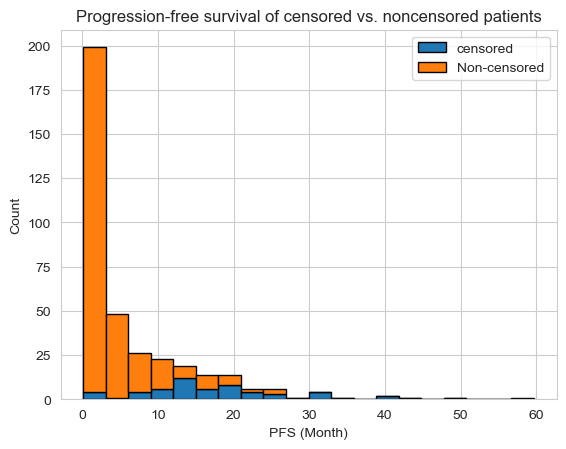

In [4]:
# Histogram code here:
plt.hist([pfs[pfs['pfs_censor']==0]['pfs'], pfs[pfs['pfs_censor']==1]['pfs']], bins=20, 
         edgecolor='k', histtype='bar',  stacked=True, label=['censored', 'Non-censored'])
plt.title("Progression-free survival of censored vs. noncensored patients")
plt.xlabel('PFS (Month)')
plt.ylabel('Count')
plt.legend();

Although these measurements with censored pfs can still be useful, our goal is to determine the impact of multi-modal data, not necessarily build the best PFS model we can. So to make this analysis cleaner, we will remove potential sources of noise and patients with censored PFS values are non-exact so we will exclude those.

Determine the indices of patients we will keep in our analysis (`idx_to_keep`) so that we only include patients with 0 < pfs < 50 and pfs_censor == 1.

In [5]:
idx_to_keep = pfs[(pfs['pfs']<50) & (pfs['pfs']>0) & (pfs['pfs_censor']==1)].index.tolist()

In [6]:
len(idx_to_keep)

307

How many patients met this inclusion criteria and are included in the idx_to_keep?

<font color='red'>

**Answer:**

307 patients met this criteria and are included. 

</font>

# 1. Prepare data for modeling
* Read in the datasets
* Split the data into train / validation / test
* Clean the datasets
* Map modalities together through shared names

First we need to create train / validation / test splits of our data. Use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to set aside 20% of the data as the test set. Then of the remaining 80% of the data, set aside 20% of that for validation. Set random_state = 0. **Recall that we only want to include the patients identified above in idx_to_keep in our train / validation / testing data**

In [7]:
train_idx, valid_idx, test_idx = None, None, None #TODO

trainval_idx, test_idx = train_test_split(idx_to_keep, random_state=0, test_size=0.2)
train_idx, valid_idx = train_test_split(trainval_idx, random_state=0, test_size=0.2)

Eventually, we will be training models based on multiple different data modalities. However, not every patient has all modalities. In `modalities.csv` we have marked which patient has which modality available, we will want to factor this into our splitting. First, read in this file. Each column contains binary indicators clarifying which modalities a patient has available. Calculate at the number of patients who have each modality. We want our train / validation / test splits to have consistent representation across the types of data each patient could have available. You will notice that every patient has the clinical modality so we will group patients based on whether they have pathology and/or radiology data. Specifically we will look at these four groups:

a) Pathology (no radiology)

b) Radiology (no pathology)

c) Pathology and radiology

d) Neither

For each of the train / validation / test splits defined above, count the number of patients who fit into each category. Make a barplot showing the percentage of patients within each dataset split that belong to a given modality group. Specifically, your bar plot should have the 4 groups (a-d) above on the x axis, the y axis should show the percentage of patients within a split that belong to that group, and the color of the bars should be the dataset split (train / valid / test). *Hint: If you format the metrics into a dataframe with columns ["Modality", "Percent of patients", "Eval split"] and use sns.barplot you can make this barplot with 1 line of code*

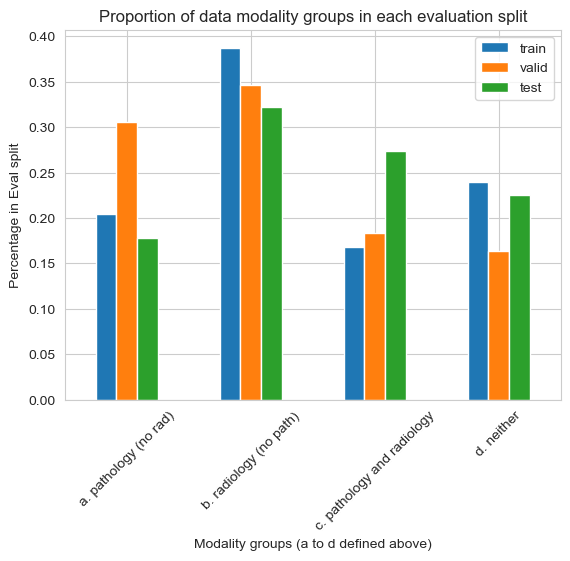

In [8]:
modalities = pd.read_csv("modalities.csv")

# Calculate the percentage of patients with each combination of modalities

modalities = modalities.loc[idx_to_keep]
modalities.loc[((modalities['has_pathology']==1) & (modalities['has_radiology']==0)), 'group'] = 'a. pathology (no rad)'
modalities.loc[((modalities['has_pathology']==0) & (modalities['has_radiology']==1)), 'group'] = 'b. radiology (no path)'
modalities.loc[((modalities['has_pathology']==1) & (modalities['has_radiology']==1)), 'group'] = 'c. pathology and radiology'
modalities.loc[((modalities['has_pathology']==0) & (modalities['has_radiology']==0)), 'group'] = 'd. neither'

# Bar plot code here:
## make dataframe of percentage 
df_train_perc = pd.DataFrame(modalities.loc[train_idx]['group'].value_counts()).reset_index().rename(columns={'count': 'train'})
df_val_perc = pd.DataFrame(modalities.loc[valid_idx]['group'].value_counts()).reset_index().rename(columns={'count': 'valid'})
df_test_perc = pd.DataFrame(modalities.loc[test_idx]['group'].value_counts()).reset_index().rename(columns={'count': 'test'})

df_mod_count = df_train_perc.merge(df_val_perc, on='group', how='inner')
df_mod_count = df_mod_count.merge(df_test_perc, on='group', how='inner')

df_mod_count.set_index('group', inplace=True)
df_mod_count = df_mod_count.div(df_mod_count.sum(axis=0), axis=1).reset_index()
df_mod_count.sort_values('group', inplace=True)
df_mod_count.plot(x='group', kind='bar', stacked=False,
        title='Stacked Bar Graph by dataframe')
plt.title("Proportion of data modality groups in each evaluation split")
plt.xlabel('Modality groups (a to d defined above)')
plt.ylabel('Percentage in Eval split')
plt.xticks(rotation=45)
plt.legend();

You should see that the modalities are not evenly represented across the splits. Now, create new `train_idx`, `valid_idx`, and `test_idx` as above but this time split it such that the representation of modalities in each of the splits. To do this, first create a list that indicates which modality group each patient belongs to. Specifically, modality counts should be a list that has values 0-3 indicating which of the 4 modality groups the patient belongs to.

Create new train / valid / test splits as above, but this time use this new list as the `stratify` parameter in `train_test_split` (both for creating the test split and the validation split!) to ensure the splits have even representation of modalities. Again, we are only interested in splitting the `idx_to_keep`.

Once you have done this, re-calculate the distribution of modality_counts within each of our dataset splits and make the same barplot as above (you can re-use the code you wrote above). You should see that this time, the splits are all balanced and all 3 bars (train / valid test) are much more similar for each modality group.

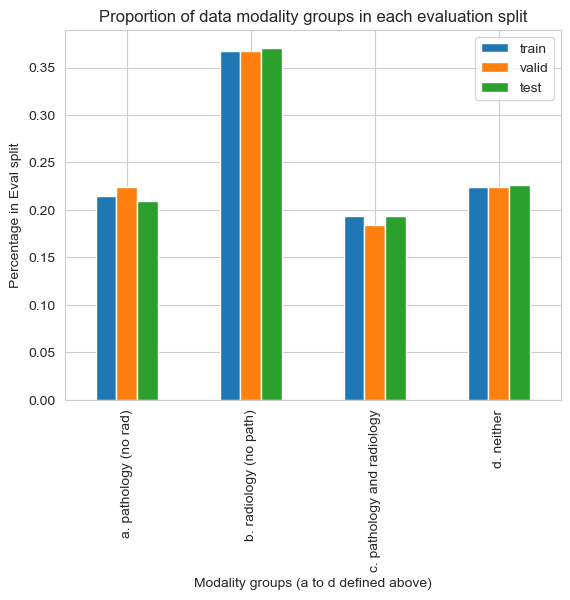

In [9]:
# Construct modality_counts
modality_counts = modalities[['group']]
# Split into train, valid, and test sets using modality_counts to stratify
# Hint: use sklearn.model_selection.train_test_split with the stratify argument

trainval_idx, test_idx = train_test_split(idx_to_keep, random_state=0, test_size=0.2, stratify=modality_counts['group'])
train_idx, valid_idx = train_test_split(trainval_idx, random_state=0, test_size=0.2,  stratify=modality_counts.loc[trainval_idx,'group'])

# # Re-calculate modality_metrics and make a new bar plot
# df_mod_count = pd.DataFrame(modalities[['group']].value_counts()).reset_index()
df_train_perc = pd.DataFrame(modalities.loc[train_idx]['group'].value_counts()).reset_index().rename(columns={'count': 'train'})
df_val_perc = pd.DataFrame(modalities.loc[valid_idx]['group'].value_counts()).reset_index().rename(columns={'count': 'valid'})
df_test_perc = pd.DataFrame(modalities.loc[test_idx]['group'].value_counts()).reset_index().rename(columns={'count': 'test'})

df_mod_count = df_train_perc.merge(df_val_perc, on='group', how='inner')
df_mod_count = df_mod_count.merge(df_test_perc, on='group', how='inner')

df_mod_count.set_index('group', inplace=True)
df_mod_count = df_mod_count.div(df_mod_count.sum(axis=0), axis=1).reset_index()
df_mod_count.sort_values('group', inplace=True)
df_mod_count.plot(x='group', kind='bar', stacked=False)
plt.title("Proportion of data modality groups in each evaluation split")
plt.xlabel('Modality groups (a to d defined above)')
plt.ylabel('Percentage in Eval split')
plt.xticks(rotation=45)
plt.legend();

Next we will read in each of the modalities. Note that all the files so far have implicitely had indices (0-365). These correspond to patients 0-365. However, the pathology and radiology files *do not have all the patients* so they have clinical_ids specifying which patients they belong to. Combine all of these feature datasets into 1 dataframe and include any row with a clinical measurement. *Hint: look into pd.concat*

In [10]:
clinical_features = pd.read_csv("clinical_features.csv")
rad_features = pd.read_csv("rad_features.csv", index_col=0)
path_features = pd.read_csv("path_features.csv", index_col=0)

print("Individual shapes: ", clinical_features.shape, path_features.shape, rad_features.shape)

clinical_features.index.rename('clinical_id', inplace=True)
all_features = clinical_features.merge(rad_features, on='clinical_id', how='left')
all_features = all_features.merge(path_features, on='clinical_id', how='left')
print("Combined shape: ", all_features.shape)

Individual shapes:  (366, 9) (157, 168) (203, 1688)
Combined shape:  (366, 1865)


In [11]:
# Sanity checks that the features are combined properly
assert all_features.shape == (clinical_features.shape[0],
                              clinical_features.shape[1] + path_features.shape[1] + rad_features.shape[1]
                              ), "Features have not all been combined correctly"

for trimodal_index in set(clinical_features.index) & set(path_features.index) & set(rad_features.index):
    for df in (clinical_features, path_features, rad_features):
        assert (all_features.loc[trimodal_index][df.columns].dropna() == df.loc[trimodal_index].dropna()).all(), f"Features are not all combined correctly"

Now let's split up our features and labels based on the train, valid, and test indices defined above. We have added all of these datasets to a class called datasets to make it easier to pass them around. You can access the training features via `ds.train_X`, the labels via `ds.train_y`, etc.

In [12]:
ds = datasets(
    train_X = all_features.loc[train_idx],
    valid_X = all_features.loc[valid_idx],
    test_X = all_features.loc[test_idx],
    train_y = pfs.loc[train_idx, "pfs"],
    valid_y = pfs.loc[valid_idx, "pfs"],
    test_y = pfs.loc[test_idx, "pfs"],
    )

## 2. Single modality modeling

First we will train a model on just the clinical features. When we combine the modalities we will have many features with missing values. XGBoost models are able to handle these well, so we will use this for our model training. Read the docs [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) for more information on this model. Feel free to play around with various hyperparameters, but for all models in this assignment make sure you set `random_state = 0`. We have written helper functions in `train_utils.py` that you can use to train and evaluate a model on a subset of the features in your datasets. Use this to train a model on *only the clinical features*.

In [13]:
clinical_features.columns

Index(['albumin', 'smoking_status', 'pack_years', 'age', 'sex', 'n_lesions',
       'liver_mets', 'brain_mets', 'site_lung'],
      dtype='object')

In [14]:
# Define XGB model
xgb = XGBRegressor(n_estimators=1000, random_state=0)

# Train and evaluate model and report metrics
preds,metrics = train_and_eval_model(xgb, ds, features_to_include=clinical_features.columns)
metrics

{'train': 0.002803707986818626,
 'valid': 5.281413286203829,
 'test': 5.512560842549424}

This model should look pretty overfit! To address this, let's optimize the hyperparameters of our model. Again in train_utils there is a function `run_hyperparameter_search` that runs a small grid search over various values for some of the XGBoost hyperparameters, the best model will be selected based on the validation loss and the RMSE on the train / valid / test sets will be reported. Use this to run a hyperparameter search and train a (hopefully less overfit) model on the clinical features.

In [15]:
# Run hyperparameter search and report metrics
best_metrics, best_params= run_hparam_search(ds, features_to_include=clinical_features.columns)

In [16]:
best_metrics, best_params

({'train': 3.8941903826859807,
  'valid': 4.661653118237783,
  'test': 4.011214913357399},
 {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 25})

# 3. Early data fusion

Describe, in 1-2 sentences (no code necessary), how you would implement:

1. Early Data Fusion

2. Intermediate Data Fusion

3. Late Data Fusion

<font color='red'>

**Answer:**

1. Concatenate all features / directly use all features within feature set to train model. 


2. For each modality, use a separate model (ex. fully connected / other neural networks) to learn a feature vector based on features available for this modality. These feature vector each representing a modality are concatenated and used for training the prediction model. 


3. Train a prediction model using features from each single modality. Then, integrate all prediction results (ex. average all scores) to make the final prediction. 

</font>

Now, train an early fusion model on each of the modality combinations (clinical, clinical + pathology, clinical + radiology, clinical + pathology + radiology). For each of these modality combinations, run a hyperparameter search using the relevant features. Make a barplot showing the results of all 4 experiments with the modalities on the x axis, and the best RMSEs on the y axis where each of the train / valid / test RMSEs are represented by a different color

In [17]:
# Define feature sets
clin_featset = clinical_features.columns.tolist()
clin_rad_featset = clinical_features.columns.tolist() + rad_features.columns.tolist()
clin_path_featset = clinical_features.columns.tolist() + path_features.columns.tolist()
clin_rad_path_featset = clinical_features.columns.tolist() + rad_features.columns.tolist() + path_features.columns.tolist()

# Train and evaluate model and report metrics
metrics_clin,best_params_clin = run_hparam_search(ds, features_to_include=clin_featset)
metrics_clin_rad,best_params_clin_rad = run_hparam_search(ds, features_to_include=clin_rad_featset)
metrics_clin_path,best_params_clin_path = run_hparam_search(ds, features_to_include=clin_path_featset)
metrics_clin_rad_path,best_params_clin_rad_path = run_hparam_search(ds, features_to_include=clin_rad_path_featset)

In [18]:
len(clin_featset), len(clin_rad_featset), len(clin_path_featset), len(clin_rad_path_featset)

(9, 1697, 177, 1865)

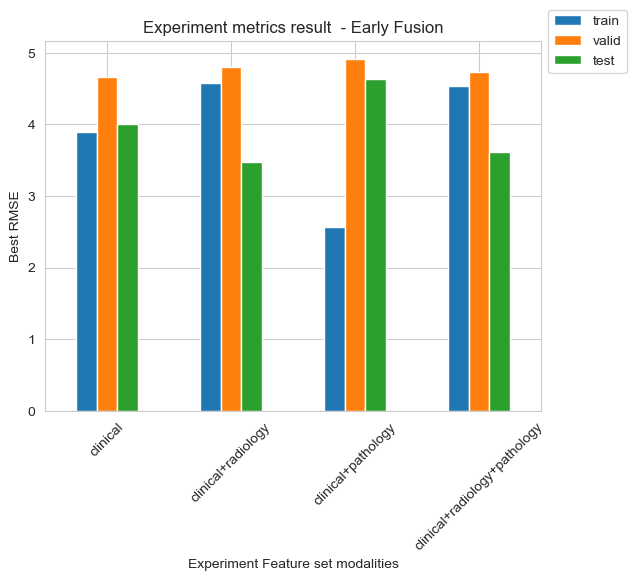

In [19]:
metrics_exp = pd.DataFrame([metrics_clin, metrics_clin_rad, metrics_clin_path, metrics_clin_rad_path])
metrics_exp['feature_set'] = ['clinical', 'clinical+radiology', 'clinical+pathology', 'clinical+radiology+pathology']

# Plot results
metrics_exp.plot(x='feature_set', kind='bar', stacked=False)
plt.title("Experiment metrics result  - Early Fusion")
plt.xlabel('Experiment Feature set modalities')
plt.ylabel('Best RMSE')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 1));

In [20]:
metrics_clin,best_params_clin, metrics_clin_rad,best_params_clin_rad, metrics_clin_path,best_params_clin_path, metrics_clin_rad_path,best_params_clin_rad_path

({'train': 3.8941903826859807,
  'valid': 4.661653118237783,
  'test': 4.011214913357399},
 {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 25},
 {'train': 4.57458738582071,
  'valid': 4.79524125660062,
  'test': 3.4770366421120755},
 {'max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 25},
 {'train': 2.5672922888455814,
  'valid': 4.9167258660495925,
  'test': 4.636132199176916},
 {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 50},
 {'train': 4.531400484819303,
  'valid': 4.736692832770467,
  'test': 3.6116508402654133},
 {'max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 25})

Note that it still looks like the multi-modal models are overfitting quite a bit as the performance on the training set is *much* better than the validation set. Looking back at the features sizes, not that there are *thousands* of pathology & radiology features. Let's reduce some of these such we keep only < 20 features from each of pathology and radiology. One way to select features is to only keep the features with the features with the highest variance in the test set. There is also a function in `train_utils` that selects features using LASSO regression. Feel free to use either of these or any other method to reduce the number of features (as long as it does not make use of values from the test set!)

Once you've down-sampled the features, print the number of selected features from each modality, then re-do the analysis from above, again running a hyperparameter search for each collection of features (this time only including a subset of the pathology and radiology features) and make another barplot with the new metrics. Report how many features you selected from each modality.

In [21]:
path_features_to_keep = select_features_with_lasso(ds, features_to_select_from=path_features.columns, alpha=0.1)
rad_features_to_keep = select_features_with_lasso(ds, features_to_select_from=rad_features.columns, alpha=0.7)

print(f"{len(path_features_to_keep)} pathology features selected")
print(f"{len(rad_features_to_keep)} radiology features selected")

20 pathology features selected
12 radiology features selected


In [22]:
len(clin_featset), len(clin_rad_featset), len(clin_path_featset), len(clin_rad_path_featset)

(9, 1697, 177, 1865)

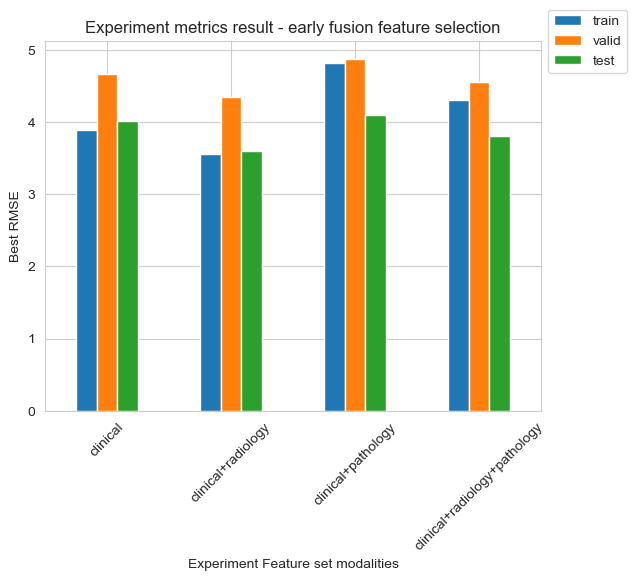

In [23]:
# Define feature sets
clin_featset = clinical_features.columns.tolist()
clin_rad_featset = clinical_features.columns.tolist() + rad_features_to_keep.tolist()
clin_path_featset = clinical_features.columns.tolist() + path_features_to_keep.tolist()
clin_rad_path_featset = clinical_features.columns.tolist() + rad_features_to_keep.tolist() + path_features_to_keep.tolist()

# Run hyperparameter search for each feature set
metrics_clin,best_params_clin = run_hparam_search(ds, features_to_include=clin_featset)
metrics_clin_rad,best_params_clin_rad = run_hparam_search(ds, features_to_include=clin_rad_featset)
metrics_clin_path,best_params_clin_path = run_hparam_search(ds, features_to_include=clin_path_featset)
metrics_clin_rad_path,best_params_clin_rad_path = run_hparam_search(ds, features_to_include=clin_rad_path_featset)

# Plot results
metrics_exp = pd.DataFrame([metrics_clin, metrics_clin_rad, metrics_clin_path, metrics_clin_rad_path])
metrics_exp['feature_set'] = ['clinical', 'clinical+radiology', 'clinical+pathology', 'clinical+radiology+pathology']

metrics_exp.plot(x='feature_set', kind='bar', stacked=False)
plt.title("Experiment metrics result - early fusion feature selection")
plt.xlabel('Experiment Feature set modalities')
plt.ylabel('Best RMSE')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 1));

# 3. Late data fusion

Now we will compare this to late fusion. First we will run a hyperparameter search for each modality individually to get 3 independent models (clinical-only, pathology-only, radiology-only)

In [24]:
# Run a hyperparameter search for each modality individually
# Define feature sets
clin_featset = clinical_features.columns.tolist()
rad_featset = rad_features_to_keep
path_featset = path_features_to_keep

# Train and evaluate model and report metrics
metrics_clin,best_params_clin = run_hparam_search(ds, features_to_include=clin_featset)
metrics_rad,best_params_rad = run_hparam_search(ds, features_to_include=rad_featset)
metrics_path,best_params_path = run_hparam_search(ds, features_to_include=path_featset)

Now, get predictions for each model on the train / validation / test sets. For each of the modality-combinations above (clinical, clinical + pathology, clinical + radiology, clinical + pathology + radiology), use late-fusion to get predictions that combine each modality and calculate the RMSEs of these new predictions on the train / validation / test sets. Report these metrics and plot them as you did earlier for early fusion.

In [25]:
# Combine the predictions from each modality and calculate the RMSE
clin_xgb = XGBRegressor(random_state=0, **best_params_clin)
preds_clin,metrics_clin = train_and_eval_model(clin_xgb, ds, features_to_include=clin_featset)

rad_xgb = XGBRegressor(random_state=0, **best_params_rad)
preds_rad,metrics_rad = train_and_eval_model(rad_xgb, ds, features_to_include=rad_featset)

path_xgb = XGBRegressor(random_state=0, **best_params_path)
preds_path,metrics_path = train_and_eval_model(path_xgb, ds, features_to_include=path_featset)

In [26]:
preds_clin_rad = {}
preds_clin_path = {}
preds_clin_path_rad = {}
for key in preds_clin.keys(): 
    preds_clin_rad[key] = np.mean(np.array([preds_clin[key], preds_rad[key]]), axis=0)
    preds_clin_path[key] = np.mean(np.array([preds_clin[key], preds_path[key]]), axis=0)
    preds_clin_path_rad[key] = np.mean(np.array([preds_clin[key], preds_rad[key], preds_path[key]]), axis=0)

In [27]:
def get_mertics(ds, preds):
    return {
            "train": np.sqrt(mean_squared_error(ds.train_y, preds['train'])),
            "valid": np.sqrt(mean_squared_error(ds.valid_y, preds['valid'])),
            "test": np.sqrt(mean_squared_error(ds.test_y, preds['test'])),
        }

In [28]:
metrics_clin_lf = get_mertics(ds, preds_clin)
metrics_clin_rad_lf = get_mertics(ds, preds_clin_rad)
metrics_clin_path_lf = get_mertics(ds, preds_clin_path)
metrics_clin_rad_path_lf = get_mertics(ds, preds_clin_path_rad)

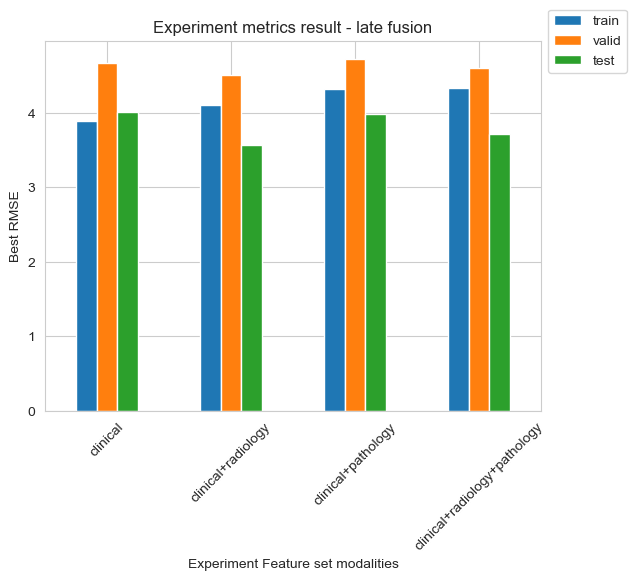

In [29]:
# Plot results
metrics_exp = pd.DataFrame([metrics_clin_lf, metrics_clin_rad_lf, metrics_clin_path_lf, metrics_clin_rad_path_lf])
metrics_exp['feature_set'] = ['clinical', 'clinical+radiology', 'clinical+pathology', 'clinical+radiology+pathology']

metrics_exp.plot(x='feature_set', kind='bar', stacked=False)
plt.title("Experiment metrics result - late fusion")
plt.xlabel('Experiment Feature set modalities')
plt.ylabel('Best RMSE')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 1));

## 4. Reflection

In 2-5 sentences, discuss the results you found. Specifically compare the performance of the different modalities, compare the results of early vs late fusion, and note the impact of feature reduction.

<font color='red'>

**Answer:**

When training with each single modality, it can be observed that performance metrics varies between the modalities. For example, model trained with clinical data overfits more than the radiology/pathology data trained models. This may due to clinical dataset having fewer features for each patient. Between early fusion and late fusion multi-modality models, it can be observed that early fusion is more prone to overfitting, with the RMSE for model trained with all 3 modalities having the largest difference in RMSE between train/validation and train/test. For the other 2 models fusing 2 datasets, clinical+radiology and clinical+pathology models, we can see that performance is largely dominated by the performance of the data type with larger feature size, i.e., the two model performance metrics are more similar to the models trained with radiology or pathology alone respectively. The clinical+pathology model presents large overfitting, as pathology data has way larger dimensionality than the clinical dataset while being smaller in terms of patient number, making the model more prone to overfitting. After feature selection, we can see that the models are overfitting less than before, with test RMSE being lower in the fusion models than train RMSE. This may likely be due to the more uniform feature size across modalities after reduction. 

For late fusion, the effect for controlling overfitting is similar to that of early fusion after feature selection. Validation RMSE is slightly higher than that of train RMSE, but test RMSE is consistenly lower than train RMSE for the 2 or 3 modality fusion models. 

</font>


Discuss tradeoffs of early vs late fusion. When might you want to use one versus the other

<font color='red'>

**Answer:**

Early fusion is easier to conduct than late fusion as it involves simple concatenation of features. Late fusion is slightly more complex, as it could involve different types of fusion methods (ex. simple averaging or applying weights to different models) for combing the individual models. 
When the feature size difference is large between different modalities and potentially hard to conduct feature selection, it is preferred to use late fusion, as we observe that it results in less overfitted results than the early fusion without any feature selection. 

</font>


We referred to the first type of data fusion as "early" fusion, however it could also be considered "intermediate" fusion. Why is this the case?


<font color='red'>

**Answer:**

The features from radiology and pathology are pre-extracted features from the medical images and histopathology images, instead of the raw images themselves. This step can utilize other deep learning neural networks for extracting feature embeddings from the images, hence fusing embeddings and training model in the 'early fusion' part of the assignment can be seen as an intermediate fusion type.  


</font>